In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import transformers


2023-04-24 10:47:05.902064: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

label_dict = {'agreed': 0, 'disagreed': 1, 'unrelated': 2}
train_df['label_num'] = train_df['label'].apply(lambda x: label_dict[x])


print(train_df.isnull().sum())
print(train_df.shape)
train_df

id           0
tid1         0
tid2         0
title1_en    0
title2_en    0
label        0
label_num    0
dtype: int64
(256442, 7)


,id,tid1,tid2,title1_en,title2_en,label,label_num
0,195611,0,1,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated,2
1,191474,2,3,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated,2
2,25300,2,4,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated,2
3,123757,2,8,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP overtakes Hong Kong? Bureau of ...,unrelated,2
4,141761,2,11,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outpaces Hong Kong? Defending R...,unrelated,2
...,...,...,...,...,...,...,...
256437,113364,167562,48447,egypt 's presidential election failed to win m...,Salah is retiring? Football Association offici...,unrelated,2
256438,49407,167562,49795,egypt 's presidential election failed to win m...,Liverpool's bid for Little Germany? The Echo's...,unrelated,2
256439,130134,167562,114783,egypt 's presidential election failed to win m...,West Media Exposing Tallahlach has been recomm...,unrelated,2
256440,101494,167562,137705,egypt 's presidential election failed to win m...,Rumor has it that Egypt is very united and the...,unrelated,2


In [3]:
print("Train Target Distribution")
print(train_df['label'].value_counts())

from numpy.random import binomial
np.random.seed(0)


grouper = train_df.groupby("label_num")
sizes = grouper.size()

fracs = (sizes.min()) / sizes

test  = pd.DataFrame()
train = pd.DataFrame()

for grp, data in grouper: # reuse the grouper!
    mask = binomial(1, fracs.loc[grp], data.shape[0]).astype(bool)
    train = train.append(data[mask])
    test  =  test.append(data[~mask])

train_df = train.sample(frac=1)
train_df

Train Target Distribution
unrelated    175598
agreed        74238
disagreed      6606
Name: label, dtype: int64


/var/folders/g6/ffg782y56_s5b_cvljcm9_sc0000gn/T/ipykernel_55722/1940800260.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(data[mask])
/var/folders/g6/ffg782y56_s5b_cvljcm9_sc0000gn/T/ipykernel_55722/1940800260.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test  =  test.append(data[~mask])
/var/folders/g6/ffg782y56_s5b_cvljcm9_sc0000gn/T/ipykernel_55722/1940800260.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(data[mask])
/var/folders/g6/ffg782y56_s5b_cvljcm9_sc0000gn/T/ipykernel_55722/1940800260.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test  =  test.append(data[~m

,id,tid1,tid2,title1_en,title2_en,label,label_num
180007,44623,119733,119734,A family of seven killed in a dispute over bri...,"See also ""bride price dispute to a family of s...",disagreed,1
4073,229756,2528,9221,New rule 2018: Drinking without driving is als...,Laying down rumors and taking a rest in the ca...,unrelated,2
81998,254434,55528,5344,how do you get the safest way to cash out the ...,2018 new jingdong white stripe encashment seco...,agreed,0
216120,95527,142459,141764,"Cars add water, a new energy source that can c...",Hydropower cars and beverages can be used as f...,agreed,0
42592,17445,29202,29220,"""Printed"", Xu Zheng will no longer invite Baer...","Baer has been ""crying"" at the scene of Xu Zhen...",unrelated,2
...,...,...,...,...,...,...,...
31794,238635,21741,2532,You can't touch a car for a few hours after dr...,"From now on, as long as you drink and do these...",agreed,0
246395,38124,161009,33835,rumor is that chengguan bridge in chongqing is...,"Rumors of ""Use of Medical Waste in a Rice Flou...",unrelated,2
135648,103112,90360,77392,"Wu Chi-lung, Liu Shih-chui was revealed to be ...",Is Liu Chirong Divorced? Why Liu Shih-shih and...,agreed,0
176604,32041,117194,117195,A man in Zhangjiakou kicked the kid with a stick.,A man with a stick beating a child? This is a ...,disagreed,1


In [4]:
max_length = 128  # Maximum length of input sentence to the model.
batch_size = 32

class BertSemanticDataGenerator(tf.keras.utils.Sequence):
    """Generates batches of data.

    Args:
        sentence_pairs: Array of premise and hypothesis input sentences.
        labels: Array of labels.
        batch_size: Integer batch size.
        shuffle: boolean, whether to shuffle the data.
        include_targets: boolean, whether to incude the labels.

    Returns:
        Tuples `([input_ids, attention_mask, `token_type_ids], labels)`
        (or just `[input_ids, attention_mask, `token_type_ids]`
         if `include_targets=False`)
    """

    def __init__(
        self,
        sentence_pairs,
        labels,
        batch_size=batch_size,
        shuffle=True,
        include_targets=True,
    ):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        # Load our BERT Tokenizer to encode the text.
        # We will use base-base-uncased pretrained model.
        self.tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-uncased", do_lower_case=True
        )
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.sentence_pairs) // self.batch_size

    def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        # With BERT tokenizer's batch_encode_plus batch of both the sentences are
        # encoded together and separated by [SEP] token.
        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_tensors="tf",
        )

        # Convert batch of encoded features to numpy array.
        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

        # Set to true if data generator is used for training/validation.
        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            return [input_ids, attention_masks, token_type_ids], labels
        else:
            return [input_ids, attention_masks, token_type_ids]

    def on_epoch_end(self):
        # Shuffle indexes after each epoch if shuffle is set to True.
        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)


In [5]:
train_labels = keras.utils.to_categorical(train_df['label_num'].values)
split = int(len(train_df) * 0.3)

train_data = BertSemanticDataGenerator(
    train_df[:split][["title1_en", "title2_en"]].values.astype("str"),
    train_labels[:split],
    batch_size=batch_size,
    shuffle=True,
)
valid_data = BertSemanticDataGenerator(
    train_df[split:][["title1_en", "title2_en"]].values.astype("str"),
    train_labels[split:],
    batch_size=batch_size,
    shuffle=True,
)



In [6]:
# Create the model under a distribution strategy scope.
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Encoded token ids from BERT tokenizer.
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )
    # Attention masks indicates to the model which tokens should be attended to.
    attention_masks = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_masks"
    )
    # Token type ids are binary masks identifying different sequences in the model.
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="token_type_ids"
    )
    # Loading pretrained BERT model.
    bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")
    # Freeze the BERT model to reuse the pretrained features without modifying them.
    bert_model.trainable = False

    bert_output = bert_model.bert(
        input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
    )
    sequence_output = bert_output.last_hidden_state
    pooled_output = bert_output.pooler_output
    # Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
    bi_lstm = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True)
    )(sequence_output)
    # Applying hybrid pooling approach to bi_lstm sequence output.
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool])
    dropout = tf.keras.layers.Dropout(0.3)(concat)
    output = tf.keras.layers.Dense(3, activation="softmax")(dropout)
    model = tf.keras.models.Model(
        inputs=[input_ids, attention_masks, token_type_ids], outputs=output
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

model.summary()


Metal device set to: AMD Radeon Pro 5300M

systemMemory: 16.00 GB
maxCacheSize: 1.99 GB

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


2023-04-24 10:47:13.136097: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 10:47:13.136967: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-24 10:47:13.137019: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 10:47:13.137234: I tensorflow/core/common_runtime/pluggable_device/plug

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)

In [7]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=10,
    use_multiprocessing=True,
    workers=-1,
)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/Ayler/opt/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
2023-04-24 10:47:28.112988: W tensorflow/core/grappler/optimizers/data/auto_shard.cc

Epoch 1/10


2023-04-24 10:47:28.251579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2023-04-24 10:47:44.845144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 10:47:52.743216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 10:47:52.776136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 10:47:54.046457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 10:47:54.092739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 44/186 [======>.......................] - ETA: 2:15 - loss: 0.9706 - acc: 0.4979

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


170/186 [==========================>...] - ETA: 14s - loss: 0.8048 - acc: 0.6232

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


178/186 [===========================>..] - ETA: 7s - loss: 0.7985 - acc: 0.6273

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


186/186 [==============================] - ETA: 0s - loss: 0.7945 - acc: 0.6304

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
2023-04-24 10:50:42.018725: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_32815"
    }
  }
}
attr {
  key: "metadata"
  value {

186/186 [==============================] - 553s 3s/step - loss: 0.7945 - acc: 0.6304 - val_loss: 0.6845 - val_acc: 0.7033
Epoch 2/10


2023-04-24 10:56:40.834252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 10:56:40.845073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  3/186 [..............................] - ETA: 2:48 - loss: 0.7461 - acc: 0.6562

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


122/186 [==================>...........] - ETA: 57s - loss: 0.6518 - acc: 0.7154

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


125/186 [===================>..........] - ETA: 55s - loss: 0.6528 - acc: 0.7130

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


186/186 [==============================] - ETA: 0s - loss: 0.6385 - acc: 0.7193

2023-04-24 10:59:29.572756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 10:59:29.580988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 10:59:29.643115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 10:59:29.651047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the re

186/186 [==============================] - 529s 3s/step - loss: 0.6385 - acc: 0.7193 - val_loss: 0.5856 - val_acc: 0.7450
Epoch 3/10


2023-04-24 11:05:30.005882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 11:05:30.017284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 24/186 [==>...........................] - ETA: 2:31 - loss: 0.5789 - acc: 0.7552

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 30/186 [===>..........................] - ETA: 2:27 - loss: 0.5801 - acc: 0.7521

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 85/186 [============>.................] - ETA: 1:36 - loss: 0.5941 - acc: 0.7390

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


186/186 [==============================] - ETA: 0s - loss: 0.5762 - acc: 0.7520

2023-04-24 11:08:28.403837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 11:08:28.413190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 11:08:28.485994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 11:08:28.495935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the re

186/186 [==============================] - 545s 3s/step - loss: 0.5762 - acc: 0.7520 - val_loss: 0.5656 - val_acc: 0.7518
Epoch 4/10


2023-04-24 11:14:35.493210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 11:14:35.502875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 62/186 [=========>....................] - ETA: 2:00 - loss: 0.5188 - acc: 0.7802

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 97/186 [==============>...............] - ETA: 1:25 - loss: 0.5319 - acc: 0.7767

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


140/186 [=====================>........] - ETA: 44s - loss: 0.5332 - acc: 0.7739

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


186/186 [==============================] - ETA: 0s - loss: 0.5389 - acc: 0.7727

2023-04-24 11:17:35.340627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 11:17:35.349468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 11:17:35.418282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 11:17:35.427410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the re

186/186 [==============================] - 550s 3s/step - loss: 0.5389 - acc: 0.7727 - val_loss: 0.5718 - val_acc: 0.7529
Epoch 5/10


2023-04-24 11:23:45.713505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 11:23:45.722608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  3/186 [..............................] - ETA: 2:57 - loss: 0.5458 - acc: 0.7708

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 45/186 [======>.......................] - ETA: 2:15 - loss: 0.4974 - acc: 0.7965

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 62/186 [=========>....................] - ETA: 1:59 - loss: 0.4962 - acc: 0.7933

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


186/186 [==============================] - ETA: 0s - loss: 0.5025 - acc: 0.7865

2023-04-24 11:26:41.525148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 11:26:41.533416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 11:26:41.593624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 11:26:41.601587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the re

186/186 [==============================] - 535s 3s/step - loss: 0.5025 - acc: 0.7865 - val_loss: 0.5376 - val_acc: 0.7651
Epoch 6/10


2023-04-24 11:32:40.620402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 11:32:40.628782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 13/186 [=>............................] - ETA: 2:39 - loss: 0.4395 - acc: 0.8149

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 50/186 [=======>......................] - ETA: 2:05 - loss: 0.4625 - acc: 0.7994

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


116/186 [=================>............] - ETA: 1:05 - loss: 0.4691 - acc: 0.7998

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


186/186 [==============================] - ETA: 0s - loss: 0.4754 - acc: 0.7975

2023-04-24 11:35:35.348562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 11:35:35.356741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 11:35:35.419865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 11:35:35.427873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the re

186/186 [==============================] - 529s 3s/step - loss: 0.4754 - acc: 0.7975 - val_loss: 0.6242 - val_acc: 0.7388
Epoch 7/10


2023-04-24 11:41:29.414545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 11:41:29.421829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


130/186 [===================>..........] - ETA: 51s - loss: 0.4457 - acc: 0.8120

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


181/186 [============================>.] - ETA: 4s - loss: 0.4452 - acc: 0.8122

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


182/186 [============================>.] - ETA: 3s - loss: 0.4454 - acc: 0.8118

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


186/186 [==============================] - ETA: 0s - loss: 0.4435 - acc: 0.8127

2023-04-24 11:44:25.227837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 11:44:25.236800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 11:44:25.304620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 11:44:25.313256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the re

186/186 [==============================] - 548s 3s/step - loss: 0.4435 - acc: 0.8127 - val_loss: 0.5492 - val_acc: 0.7666
Epoch 8/10


2023-04-24 11:50:37.147880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 11:50:37.157098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 85/186 [============>.................] - ETA: 1:39 - loss: 0.4092 - acc: 0.8335

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 86/186 [============>.................] - ETA: 1:38 - loss: 0.4086 - acc: 0.8343

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


157/186 [========================>.....] - ETA: 28s - loss: 0.4060 - acc: 0.8336

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


186/186 [==============================] - ETA: 0s - loss: 0.4154 - acc: 0.8288

2023-04-24 11:53:40.315603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 11:53:40.324571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 11:53:40.394080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 11:53:40.402940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the re

186/186 [==============================] - 567s 3s/step - loss: 0.4154 - acc: 0.8288 - val_loss: 0.5340 - val_acc: 0.7690
Epoch 9/10


2023-04-24 12:00:04.022015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 12:00:04.030727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  8/186 [>.............................] - ETA: 2:52 - loss: 0.3928 - acc: 0.8477

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 50/186 [=======>......................] - ETA: 2:13 - loss: 0.3697 - acc: 0.8512

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


178/186 [===========================>..] - ETA: 8s - loss: 0.3793 - acc: 0.8432

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


186/186 [==============================] - ETA: 0s - loss: 0.3821 - acc: 0.8416

2023-04-24 12:03:10.931902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 12:03:10.940893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 12:03:11.011163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 12:03:11.020609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the re

186/186 [==============================] - 565s 3s/step - loss: 0.3821 - acc: 0.8416 - val_loss: 0.5581 - val_acc: 0.7687
Epoch 10/10


2023-04-24 12:09:29.106123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 12:09:29.115092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 52/186 [=======>......................] - ETA: 2:13 - loss: 0.3420 - acc: 0.8546

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


155/186 [========================>.....] - ETA: 30s - loss: 0.3469 - acc: 0.8526

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


181/186 [============================>.] - ETA: 4s - loss: 0.3502 - acc: 0.8526

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


186/186 [==============================] - ETA: 0s - loss: 0.3516 - acc: 0.8520

2023-04-24 12:12:33.288435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 12:12:33.297750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 12:12:33.368283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 12:12:33.377246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the re

186/186 [==============================] - 563s 3s/step - loss: 0.3516 - acc: 0.8520 - val_loss: 0.5791 - val_acc: 0.7498


In [27]:
# Unfreezez the bert_model.
bert_model.trainable = True
# Recompile the model to make the change effective.
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()

history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=2,
    use_multiprocessing=True,
    workers=-1,
)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]',    

/Users/Ayler/opt/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
2023-04-24 15:11:17.902347: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  

Epoch 1/2


2023-04-24 15:11:18.030070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 15:11:18.041190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 15:11:18.165298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 15:11:18.176234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-04-24 15:11:37.271800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
2023-04-24 15:12:03.561216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 15:12:03.603864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 15:12:05.537076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 15:12:05.589489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.

  7/186 [>.............................] - ETA: 25:48 - loss: 0.1862 - accuracy: 0.9286

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


122/186 [==================>...........] - ETA: 4:22 - loss: 0.2018 - accuracy: 0.9283

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


186/186 [==============================] - ETA: 0s - loss: 0.2008 - accuracy: 0.9276

2023-04-24 15:24:35.645125: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_355801"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:427"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
       

186/186 [==============================] - 1481s 8s/step - loss: 0.2008 - accuracy: 0.9276 - val_loss: 0.5432 - val_accuracy: 0.7863


2023-04-24 15:35:59.597155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 15:35:59.604766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 2/2
 15/186 [=>............................] - ETA: 10:20 - loss: 0.1560 - accuracy: 0.9583

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 30/186 [===>..........................] - ETA: 9:11 - loss: 0.1440 - accuracy: 0.9646

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


 79/186 [===========>..................] - ETA: 6:15 - loss: 0.1395 - accuracy: 0.9660

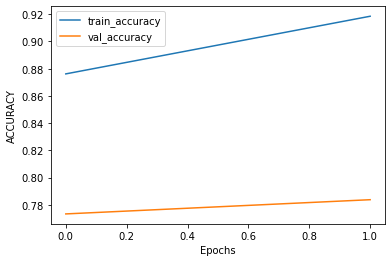

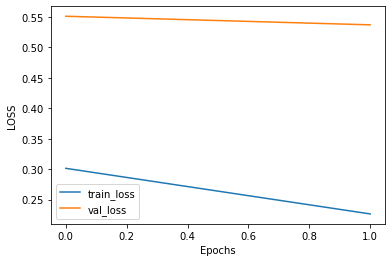

In [25]:
import plot
plot.plot_history(history, 'accuracy', 'val_accuracy')
plot.plot_history(history, 'loss', 'val_loss')

In [26]:
model.save('./data/')

INFO:tensorflow:Assets written to: ./data/assets


INFO:tensorflow:Assets written to: ./data/assets


In [16]:

lmodel = tf.keras.models.load_model('./data/')



In [19]:
labels = ['agreed','disagreed','unrelated']

def check_similarity(sentence1, sentence2):
    sentence_pairs = np.array([[str(sentence1), str(sentence2)]])
    test_data = BertSemanticDataGenerator(
        sentence_pairs, labels=None, batch_size=1, shuffle=False, include_targets=False,
    )

    # proba = model.predict(test_data[0])[0]
    # idx = np.argmax(proba)
    # proba = f"{proba[idx]: .2f}%"
    # pred = labels[idx]
    # return pred, proba
    return model.predict(test_data[0])

In [21]:

sentence1 = "How to discriminate oil from gutter oil by means of garlic."
sentence2 = "Differential gutter oil can be identified with a single piece of garlic."
check_similarity(sentence1, sentence2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
2023-04-24 13:58:57.983440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-24 13:58:57.991813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


array([[0.8505473 , 0.01788865, 0.13156402]], dtype=float32)